In [1]:
# Importa as bibliotecas necessárias
%run '~/git/Bibliotecas.ipynb'

### 1.Fertilizantes  

In [2]:
# Carrega a base de dados contendo os registros de importação de fertilizantes
i=pd.read_csv('~/git/Pricing-Fertilizer-take-Rains-into-account/temp/imp1.csv')
i.head()

,CO_ANO,CO_MES,CO_NCM,CO_UNID,CO_PAIS,SG_UF_NCM,CO_VIA,CO_URF,QT_ESTAT,KG_LIQUIDO,VL_FOB,VL_FRETE,VL_SEGURO
0,1997,1,31010000,10,386,SP,1,817800,15222,15222,34324,1323,177
1,1997,1,31010000,10,573,SP,1,817800,1800,20000,7169,2638,0
2,1997,1,31021010,10,850,RR,7,260151,640,32000,7360,1120,0
3,1997,1,31021090,10,850,RR,7,260151,96000,96000,22080,3360,0
4,1997,1,31022100,10,23,GO,1,817800,1900000,1900000,184300,19000,0


Visualizando a tabela podemos intuir:  

* Colunas ordinais:
    * CO_ANO: ano do regitro
    * CO_MES: mês do registro

* Colunas categóricas:
    * CO_ANO e CO_MES: além do valor ordinal, essas colunas representam também valor categórico, ligados ao clima do momento indicaddo.
    * CO_NCM: NCM-Nomenclatura Comum do Mercosul, que identifica o produto com base no Sistema Internacional (SH) da Organização Mundial do Comércio, acrescido de mais dois digitos extras, que especificam ainda mais as características das mercadorias importadas.
    * CO_UNID: unidade monetária de valor utilizada no registro, que é identificada textualmente em tabela auxiliar.
    * CO_PAIS: país de origem, que é identificado textualmente em tabela auxiliar.
    * CO_VIA:  via física de transporte, que é identificada textualmente em tabela auxiliar.
    * CO_URF:  Unidade da Receita Federal, que é ligada ao um porto de desembarque, que é identificada textualmente em tabela auxiliar.
    * SG_UF_NCM: contém a sigla unidade federativa de destino da importação, que é identificada textualmente em tabela auxiliar.

  
* Colunas quantitativas:
    * QT_ESTAT: contém a quantidade de produto importado em unidade tipicamente utilizada no país de origem, que pode ser diferente do padrão principal, que é o quilograma.
    * KG_LIQUIDO contém o peso da importação em quilograma
    * VL_FOB quantifica o valor monetário da mercadoria na modalidade [FOB](https://pt.wikipedia.org/wiki/Free_on_Board#:~:text=Na%20modalidade%20FOB%2C%20o%20remetente,do%20seguro%20a%20partir%20da%C3%AD.)
    * VL_FRETE quantifica o valor do transporte da quantidade importada, do país de origem até o Brasil.
    * VL_SEGURO quantifica o valor do seguro sobre a mercadoria durante o transporte do país de origem até o Brasil.

In [3]:
i.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100430 entries, 0 to 100429
Data columns (total 13 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   CO_ANO      100430 non-null  int64 
 1   CO_MES      100430 non-null  int64 
 2   CO_NCM      100430 non-null  int64 
 3   CO_UNID     100430 non-null  int64 
 4   CO_PAIS     100430 non-null  int64 
 5   SG_UF_NCM   100430 non-null  object
 6   CO_VIA      100430 non-null  int64 
 7   CO_URF      100430 non-null  int64 
 8   QT_ESTAT    100430 non-null  int64 
 9   KG_LIQUIDO  100430 non-null  int64 
 10  VL_FOB      100430 non-null  int64 
 11  VL_FRETE    100430 non-null  int64 
 12  VL_SEGURO   100430 non-null  int64 
dtypes: int64(12), object(1)
memory usage: 10.0+ MB


In [4]:
i.CO_ANO.unique()

array([1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,
       2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018,
       2019, 2020, 2021, 2022, 2023, 2024])

In [5]:
i.CO_MES.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

Não há valores inválidos e ano e mês estão dentro da faixa de valores esperados.

In [6]:
i.duplicated().sum()

0

Não há valores duplicados.

In [7]:
i.duplicated(subset=['CO_ANO','CO_MES','CO_NCM','CO_PAIS','CO_URF','SG_UF_NCM','CO_VIA']).sum()

0

Não há valores duplicados no subconjunto de categorias, e se pode concluir com isso que cada linha da tabela representa uma importação única.

### Filtragem de caracteríticas exigidas no projeto:  

Considerando que todos os registros são importações de fertilizantes, as características de interesse são:  
* desembarques ocorridos através dos portos de Salvador e Aratú, no Estado da Bahia
* importações executadas por empresas sediadas no Estado da Bahia

Para identificar essas características listadas acima, serão filtrados registros onde:  

* as Unidades da Receita Federal brasileira, receptoras da importação,  contenham em seu nome alusão aos nomes dos portos, no caso, Aratu e Salvador.
* as Unidades Federativas da empresa importadora contenham a sigla do Estado da Bahia, BA.

In [8]:
# Carrega tabela auxiliar com o nome das URF
urf=pd.read_csv('~/git/BD/Comexstat/URF.csv',encoding='Latin-1',sep=';')

# Identifica as URF que contenham no nome os nomes dos portos desejados, Aratu e Salvador.
urf_salvador_aratu=urf[(urf.NO_URF.str.contains('ARATU'))|(urf.NO_URF.str.contains('SALVADOR'))].CO_URF

# Filtra importações ligadas as URF identificadas e destinadas ao estado da Bahia
i=i[(i.CO_URF.isin(urf_salvador_aratu))&(i.SG_UF_NCM=='BA')]

### Seleciona as colunas de interesse desta fase do projeto:

As colunas de ano e mês são de interesse e serão mantidas.

As colunas utilizadas nas filtragens acima, CO_URF e SG_NCM_UF, tiveram a lista de seus possíveis valores reduzida, ficando estas colunas sem importância e por isso serão ambas descartadas.

In [9]:
i.drop(columns=['CO_URF','SG_UF_NCM'],inplace=True)

Nessa primeira tentativa do projeto, em nome da simplicidade, não serão diferenciados os fertilizantes por NCM, sendo todos considerados um único produto simplesmente denominado "fertilizante". Assim, a coluna referente ao código NCM perde importância e não será mantida.

In [10]:
i.drop(columns='CO_NCM',inplace=True)

O projeto não tem plano de utilizar os dados sobre o país de origem e essa coluna será descartada.

In [11]:
i.drop(columns='CO_PAIS',inplace=True)

A coluna sobre a via de transporte apresenta praticamente todos os valores ligados a via de código "1". Assim, somente registros ligados a essa via serão mantidos e a coluna será descartada.

In [12]:
i.groupby('CO_VIA')['KG_LIQUIDO'].sum().sort_values()

CO_VIA
4            201
1    22033169330
Name: KG_LIQUIDO, dtype: int64

In [13]:
i=i[i.CO_VIA==1]

Antes de descarta a coluna referente a via de transporte internacional, será feita uma conferência em relação a essa via ser igual ao conhecimento geral, que atribui a essa via ser marítima. Para isso será utilizada a tabela auxiliar que permite identificar nominalmente a via 1.

In [14]:
via=pd.read_csv('~/git/BD/Comexstat/VIA.csv', encoding='Latin-1',sep=';')
via.head(1)

,CO_VIA,NO_VIA
0,10,ENTRADA/SAIDA FICTA


In [15]:
print(f'É "{via[via.CO_VIA==1].NO_VIA.str.contains("MARITIMA").values[0]}" que a via de código "1" é marítima.')

É "True" que a via de código "1" é marítima.


In [16]:
i.drop(columns='CO_VIA',inplace=True)

Abaixo podemos constatar que todos os registros de importação utilizam a unidade quantitativa de código 10. Assim a coluna fica sem utilidade e será descartada. Porém , antes do descarte, confirmaremos que a unidade de valor é expressa e quilograma, como acreditamos ser.

In [17]:
i.groupby('CO_UNID')['KG_LIQUIDO'].sum().sort_values()

CO_UNID
10    22033169330
Name: KG_LIQUIDO, dtype: int64

In [18]:
unid=pd.read_csv('~/git/BD/Comexstat/NCM_UNIDADE.csv', encoding='Latin-1',sep=';')
unid.head(1)

,CO_UNID,NO_UNID,SG_UNID
0,10,QUILOGRAMA LIQUIDO,KGL


In [19]:
print(f'É "{unid[unid.CO_UNID==10].NO_UNID.str.contains("QUILOGRAMA").values[0]}" que a unidade de código "10" é quilograma.')

É "True" que a unidade de código "10" é quilograma.


In [20]:
i.drop(columns='CO_UNID',inplace=True)

A coluna 'QT_STAT' representa a quantidade importada expressa em unidades utilizadas no país de origem, que podem ser diferentes de quilograma. Isso não é de interesse do projeto e a coluna também será descartada.

In [21]:
i.drop(columns='QT_ESTAT', inplace=True)

As colunas com valores monetários não são do interesse deste projeto e serã todas descartadas.

In [22]:
i.drop(columns=['VL_FOB','VL_FRETE','VL_SEGURO'],inplace=True)

Após eliminações de tantas colunas categóricas  a tabela restante perde diferenciação entre registros e passa a apresentar duplicatas:

In [23]:
i.duplicated(subset=['CO_ANO','CO_MES']).sum()

4166

Procederemos o agrupamento nas categorias remanecentes, passando os registros a indicar a importação total de fertilizantes em um único mês de cada ano.

In [24]:
i=i.groupby(by=['CO_ANO','CO_MES']).KG_LIQUIDO.sum().reset_index()
print(f"O número de duplicatas após o reagrupamento é de {i.duplicated(subset=['CO_ANO','CO_MES']).sum()}.")

O número de duplicatas após o reagrupamento é de 0.


### Validação dos pesos declarados

Os pesos em quilograma são todos maiores do que zero.

In [25]:
i[i.KG_LIQUIDO<=0]

,CO_ANO,CO_MES,KG_LIQUIDO


Vejamos a normalidade da distribuição dos pesos em quilograma registrados:

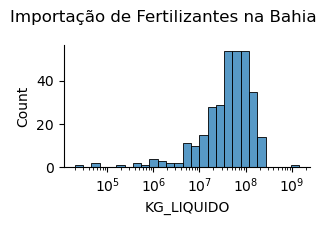

In [26]:
g=sns.displot(height=2, aspect=1.618,data=i,x='KG_LIQUIDO',log_scale=True)
g.fig.suptitle('Importação de Fertilizantes na Bahia',y=1.1)
plt.show()

Os valores menores do que 10**6.3 são considerados anormais e serão descartados.

In [27]:
i=i[i.KG_LIQUIDO>10**6.3]

Um registro apresenta peso muito acima da normalidade, próximo de 10**9 KG_LIQUIDO.

In [28]:
i[i.KG_LIQUIDO==i.KG_LIQUIDO.max()]

,CO_ANO,CO_MES,KG_LIQUIDO
78,2003,8,1420253045


Ele será substituido por interpolação dos valores do mesmo mês porém do ano anterior e do ano posterior.

In [29]:
CO_ANO_erro=i[i.KG_LIQUIDO==i.KG_LIQUIDO.max()].CO_ANO.values[0]
CO_ANO_corr_anterior=i[i.CO_ANO==CO_ANO_erro+1].CO_ANO.values[0]
CO_ANO_corr_posterior=i[i.CO_ANO==CO_ANO_erro-1].CO_ANO.values[0]
mes_erro=i[i.KG_LIQUIDO==i.KG_LIQUIDO.max()].CO_MES.values[0]
val_corr=i[i.CO_ANO.isin([CO_ANO_corr_anterior,CO_ANO_corr_posterior])].KG_LIQUIDO.mean()
i.loc[i.KG_LIQUIDO==i.KG_LIQUIDO.max(),'KG_LIQUIDO']=val_corr

A distribição dos pesos registrados ficou como a seguir e foi considerada normal.

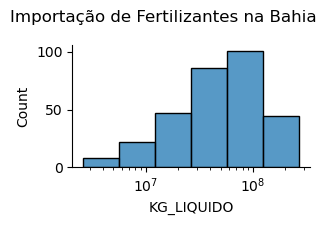

In [30]:
sns.displot(height=2, aspect=1.618,data=i,x='KG_LIQUIDO',log_scale=True, bins=6).fig.suptitle('Importação de Fertilizantes na Bahia',y=1.1)
plt.show()

In [31]:
# Cria luna com a data completa e no formato apropriado
i['date']=pd.to_datetime(i.CO_ANO.astype(str)+'/'+i.CO_MES.astype(str)+'/1')

Para conferência ampla, a seguir podemos ver as ocorrências por mês ao longo dos anos.

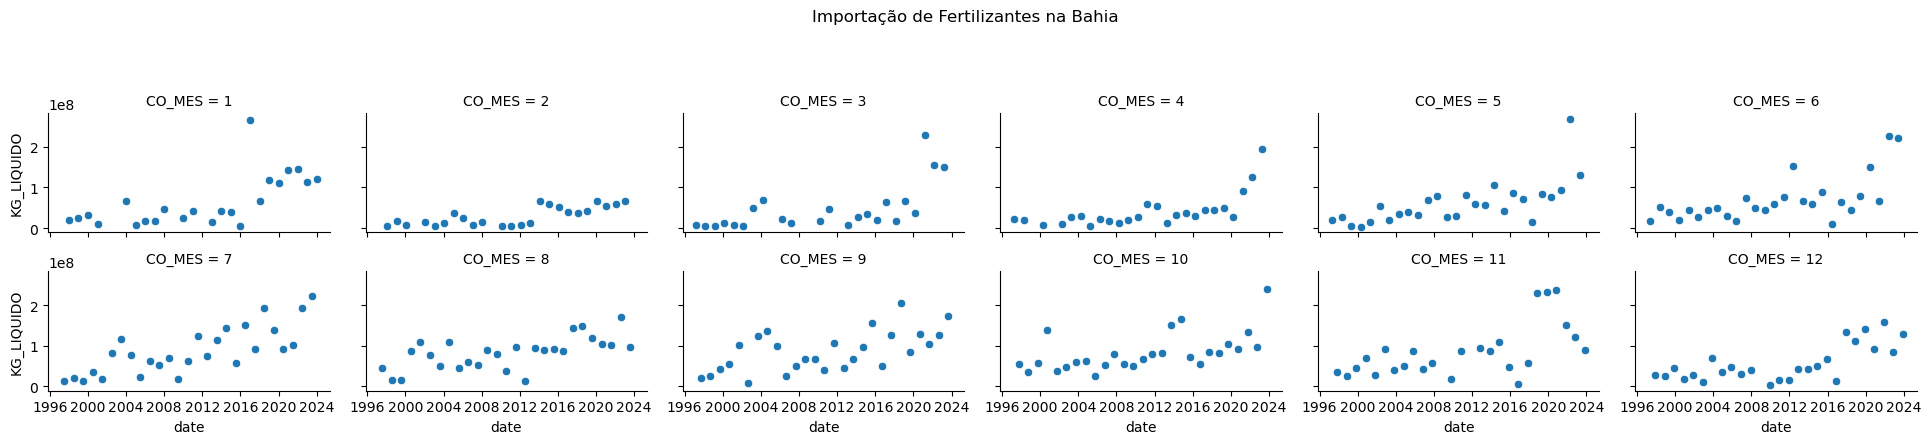

In [32]:
g=sns.relplot(height=2, aspect=1.618,data=i,x='date',y='KG_LIQUIDO',col='CO_MES',col_wrap=6)
g.fig.suptitle('Importação de Fertilizantes na Bahia',y=1.1)
#g.set_xticklabels(rotation=90)
plt.tight_layout()

A tabela e transformada para o formato de martiz esparsa, o que permitirá ela ser fundida adiante com a tabela de chuvas, que passará pelo mesmo processo, evitando a perda de registros.

In [33]:
# Martiz Esparsa
i_ini=i.date.min()
i_fim=i.date.max()
i[['CO_ANO','CO_MES']]=i[['CO_ANO','CO_MES']].astype('category')
i2=i.groupby(by=['CO_ANO','CO_MES']).KG_LIQUIDO.sum().reset_index()
i2['date']=pd.to_datetime(i2.CO_ANO.astype(str)+'/'+i2.CO_MES.astype(str)+'/1')
i2=i2[(i2.date>=i_ini)&(i2.date<=i_fim)]

In [34]:
i=i2

In [35]:
i.to_csv('~/git/Pricing-Fertilizer-take-Rains-into-account/temp/i.csv',index=False)

### 2.Chuvas

In [36]:
# Importa as bibliotecas necessárias
%run '~/git/Bibliotecas.ipynb'

In [37]:
# Carrega a tabela com histórico das chuvas no oeste baiano
c=pd.read_csv('/home/andre301267/git/Pricing-Fertilizer-take-Rains-into-account/temp/chuvas1.csv')

Seleciona colunas de interesse e unifica colunas que estavam em duplicidade.

In [38]:
c=c[c.columns[[20,0,21,1,22,2]]]
c.columns=['Estação','date1','date2','hora1','hora2','mm']
c.date1=pd.to_datetime(c.date1+'-'+c.hora1)
c.date2=pd.to_datetime(c.date2+'-'+c.hora2)
c['date']=pd.to_datetime(pd.concat([c.date1.dropna(),c.date2.dropna()]), utc=True)
c['CO_ANO']=c.date.dt.year
c['CO_MES']=c.date.dt.month
c['Dia']=c.date.dt.day
c['Hora']=c.date.dt.hour
c=c[c.columns[[0,6,7,8,9,10,5]]]
c.head(1)

,Estação,date,CO_ANO,CO_MES,Dia,Hora,mm
0,BARREIRAS,2002-01-01 00:00:00+00:00,2002,1,1,0,0


Substitui valores inválidos, transforma formatação numérica para o formato desejado.

In [39]:
c.loc[c.mm=='-9999','mm']=np.nan
c.mm=c.mm.str.replace(',','.')
c.mm=c.mm.astype('float')

Não há valores duplicados.

In [40]:
c.duplicated().sum()

0

Há aproximadamente cem mil falhas nos registros de chuvas por hora.

In [41]:
c.isna().sum()

Estação         0
date            0
CO_ANO          0
CO_MES          0
Dia             0
Hora            0
mm         103001
dtype: int64

Os registros com falha e sem falhas são separados em tabelas próprias.

In [42]:
c_na=c[(c.mm.isna())]
c_not_na=c[~(c.mm.isna())]

In [43]:
print(f"As importações com falha no registro de chuvas correspondem a {round(100*len(c_na)/len(c))} % do total")

As importações com falha no registro de chuvas correspondem a 19 % do total


A seguir se modifica a tabela com falhas no registro de forma a permitir a análise gráfica da distribuição das falhas ao longo das categorias existentes, com objetivo de verificar se há algum relacionamento lógico para as ocorrências.



Apenas 4 % apresentam ocorrência de chuva. Os demais registros apresentam ausência de chuva.
Esse fato faz com que a mediana seja sempre igual a zero, impedindo o uso dela para substituir as centenas de milhares de valores nulos
encontrados na tabela.




                  Horas com Falha no Registro de Chuvas





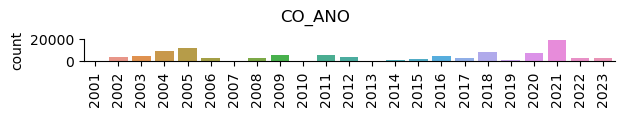

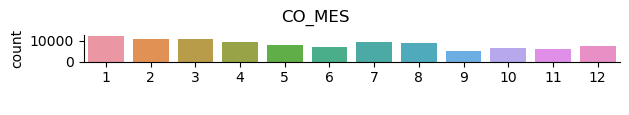

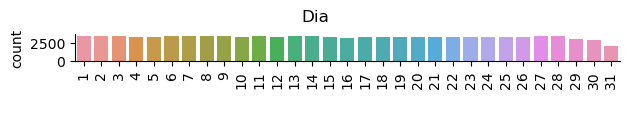

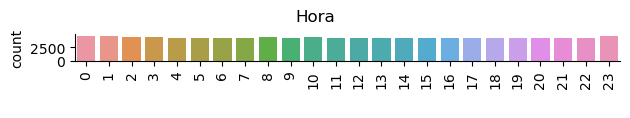

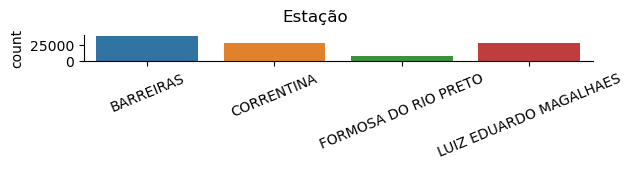


Conclsão: As falhas no registro de chuva aparentam estar normalmente distribuidas entre as categorias,
não sendo identificado relação entre elas.






In [44]:
w=pd.concat([\
c_na.groupby('CO_ANO' ).CO_MES.count().reset_index().rename(columns={'CO_MES':'count','CO_ANO':' '}).assign(tipo='CO_ANO' ),
c_na.groupby('CO_MES' ).CO_ANO.count().reset_index().rename(columns={'CO_ANO':'count','CO_MES':' '}).assign(tipo='CO_MES' ),
c_na.groupby('Dia'    ).CO_ANO.count().reset_index().rename(columns={'CO_ANO':'count','Dia':' '}).assign(tipo='Dia'    ),
c_na.groupby('Hora'   ).CO_ANO.count().reset_index().rename(columns={'CO_ANO':'count','Hora':' '}).assign(tipo='Hora'   ),
c_na.groupby('Estação').CO_ANO.count().reset_index().rename(columns={'CO_ANO':'count','Estação':' '}).assign(tipo='Estação')])

for t in w.tipo.unique():
    w_t=w[w.tipo==t]
    sns.catplot(height=1,aspect=4*1.6,data=w_t,x=' ',y='count',kind='bar').fig.suptitle(t,y=1.1)
    plt.xticks(rotation=90)
    if t =='Estação':
        plt.xticks(rotation=22.5)
    elif t=='CO_MES':
        plt.xticks(rotation=0)
print(f"\n\nApenas {round(100*len(c_not_na[c_not_na.mm!=0])/len(c_not_na))} % apresentam ocorrência de chuva. Os demais registros apresentam ausência de chuva.\n\
Esse fato faz com que a mediana seja sempre igual a zero, impedindo o uso dela para substituir as centenas de milhares de valores nulos\n\
encontrados na tabela.")

print('\n\n\n\n                  Horas com Falha no Registro de Chuvas\n\n\n')
plt.show()

print('\nConclsão: As falhas no registro de chuva aparentam estar normalmente distribuidas entre as categorias,\
\nnão sendo identificado relação entre elas.\n\n\n\n')

A seguir analizaremos a normalidade da distribuição dos registros de chuva. A cada aprovação de normalidade, se elimina a menor subdivisão de tempo, reagrupando, até chegar na subdvisão de tempo por mês, que é a medida de tempo foco deste projeto.

In [45]:
# Cria nova coluna com volume de chuva em unidade logarítmica
c_not_na['mm_hora_log']=np.log10(c_not_na.mm)

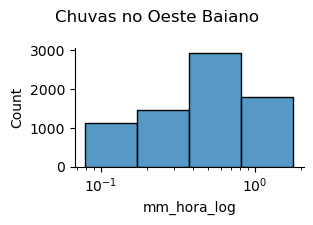

In [46]:
# Plota volumes logarítmos de chuva por hora em gráfico com escala logarítmica (duplo logaritmo)
sns.displot(height=2, aspect=1.618,data=c_not_na[c_not_na.mm_hora_log!=0],x='mm_hora_log',log_scale=True, bins=4).fig.suptitle('Chuvas no Oeste Baiano',y=1.1)
plt.show()

A distribuição de dos volumes de chuva por hora foram considerados normais.
A seguir se agrupam-se os valores por dia.

In [47]:
c_dia=c_not_na.groupby(by=c_not_na.columns[[0,1,2,3,4]].tolist())[['mm']].sum().reset_index()
c_dia.head(1)

,Estação,date,CO_ANO,CO_MES,Dia,mm
0,BARREIRAS,2001-12-20 15:00:00+00:00,2001,12,20,2.0


Recria-se a coluna com volume de chuva logarítmico.

In [48]:
c_dia['mm_dia_log']=np.log10(c_dia.mm)

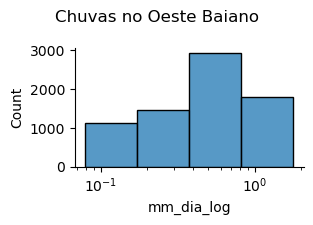

In [49]:
# Plota-se novamente os volumes logarítmicos de chuva em gráfico com escala logarítmica
sns.displot(height=2, aspect=1.618,data=c_dia[c_dia.mm_dia_log!=0],x='mm_dia_log',log_scale=True, bins=4).fig.suptitle('Chuvas no Oeste Baiano',y=1.1)
plt.show()

Nos dois gráficos apresentados acima podemos notar:  

> Devido a grande amplitude nos volumes de chuvas registrados, para possibilitar a visualização da curva normal, foi necessário aplicar duas vezes seguidas a transformação logarítmica aos volumes de chuva:
> * primeiro: transformando diretamente o valor medido para logarítmo
> * segundo: utilizando no gráfico a escala logarítmica

Agrupa-se a tabela por mês

In [50]:
c_mes=c_dia.groupby(by=['Estação','CO_ANO','CO_MES']).mm.sum().reset_index().rename(columns={'mm':'mm_mes'})

Com os agrupamentos até aqui procedidos, não é mais necessário a dupla transofrmação logaritmica, mas ainda é necessário a escala logarítmica no gráfico, para se visualizar a curva normal d distribuição de chuvas por mês.

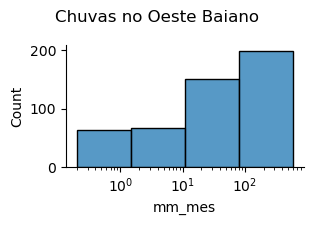

In [51]:
sns.displot(height=2, aspect=1.618,data=c_mes[c_mes.mm_mes!=0],x='mm_mes',log_scale=True, bins=4).fig.suptitle('Chuvas no Oeste Baiano',y=1.1)
plt.show()

Para simplificar, levaremos em conta apenas um linha do tempo de registros de chuva, sendo a seguir eleiminada a subdivisão referente as estações meteorológicas e agrupando os dados utilizando os valores medianos entre as estações.

In [52]:
print(f"\nApós realizar todos os agrupamentos, {round(100*len(c_mes[c_mes.mm_mes!=0])/len(c_mes))} % apresentam ocorrência de chuva e os demais registros apresentam ausência de chuva.\n\
Esse fato faz com que a mediana seja em sua maioria maior que zero, permitindo o uso dela para a conjunção dos dados entre estações.\n\n")


Após realizar todos os agrupamentos, 73 % apresentam ocorrência de chuva e os demais registros apresentam ausência de chuva.
Esse fato faz com que a mediana seja em sua maioria maior que zero, permitindo o uso dela para a conjunção dos dados entre estações.




In [53]:
c=c_mes.groupby(by=['CO_ANO','CO_MES']).mm_mes.median().reset_index()

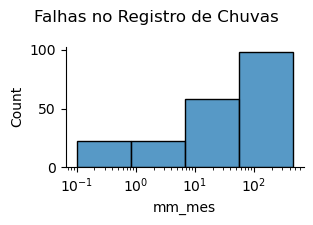

In [54]:
sns.displot(height=2, aspect=1.618,data=c[c.mm_mes!=0],x='mm_mes',log_scale=True,bins=4).fig.suptitle('Falhas no Registro de Chuvas',y=1.1)
plt.show()

Após realizar todos os agrupamentos necessários até alcançar a unidade de tempo desejada, por fim, os dados são considerados normais.

In [55]:
# Cria coluna com data completa e no formato adequado
c['date']=pd.to_datetime(c.CO_ANO.astype(str)+'/'+c.CO_MES.astype(str)+'/1')

In [56]:
# Cria matriz esparsa, com o mesmo objetivo do que foi feito com a tabela de imortações
c_ini=c.date.iloc[0]
c_fim=c.date.iloc[-1]
c[['CO_ANO','CO_MES']]=c[['CO_ANO','CO_MES']].astype('category')
c=c.groupby(by=['CO_ANO','CO_MES']).mm_mes.sum().reset_index()
c[['CO_ANO','CO_MES']]=c[['CO_ANO','CO_MES']].astype('int')
c['date']=pd.to_datetime(c.CO_ANO.astype(str)+'/'+c.CO_MES.astype(str)+'/1')
c=c[(c.date>=c_ini)&(c.date<=c_fim)]
c=c.rename(columns={'mm_mes':'mm'})
c=c.sort_values(by=['date'])
c

,CO_ANO,CO_MES,mm,date
11,2001,12,23.2,2001-12-01
12,2002,1,0.0,2002-01-01
13,2002,2,0.0,2002-02-01
14,2002,3,28.0,2002-03-01
15,2002,4,17.8,2002-04-01
...,...,...,...,...
271,2023,8,14.8,2023-08-01
272,2023,9,0.8,2023-09-01
273,2023,10,38.7,2023-10-01
274,2023,11,39.8,2023-11-01


Análise de tendência delongo prazo nos volums de chuva

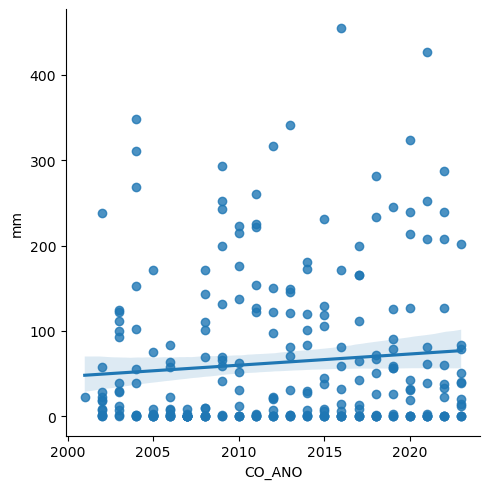

In [57]:
sns.lmplot(data=c,x='CO_ANO',y='mm')

Considerando o intervalo de confiança se pode dizer que não há alta confiança para se afirmar que há tendência de longo prazo diferente de zero. Assim, essa etapa não será executada para as chuvas.

In [58]:
c.to_csv('~/git/Pricing-Fertilizer-take-Rains-into-account/temp/c.csv',index=False)

### 3. Visualização Gráfica da Relação entre Importações e Chuvas

In [1]:
# Importa as bibliotecas necessárias
%run '~/git/Bibliotecas.ipynb'
from sklearn.preprocessing import MinMaxScaler as mms
mms=mms()
from sklearn import metrics

In [2]:
# Carrega as tabelas
i=pd.read_csv('~/git/Pricing-Fertilizer-take-Rains-into-account/temp/i.csv')
c=pd.read_csv('~/git/Pricing-Fertilizer-take-Rains-into-account/temp/c.csv')

# Funde as tabelas
i_c=i.merge(c)

# Seleciona e ordena as colunas
i_c=i_c[i_c.columns[[3,0,1,2,4]]]
i_c.date=i_c.date.astype('datetime64[ns]')
i_c.head(1)

,date,CO_ANO,CO_MES,KG_LIQUIDO,mm
0,2001-12-01,2001,12,28011377.0,23.2


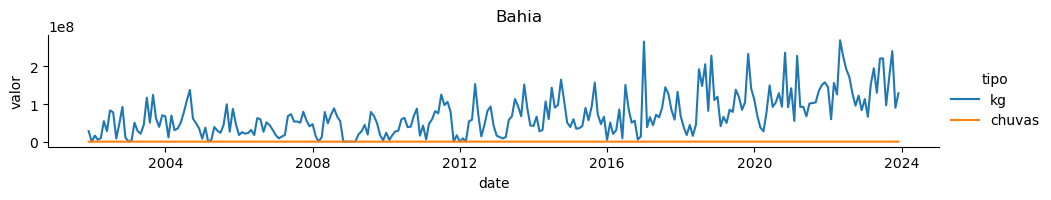

In [3]:
icl=pd.concat([
    i_c[['date','KG_LIQUIDO']].rename(columns={'KG_LIQUIDO':'valor'}).assign(tipo='kg'),
    i_c[['date','mm'        ]].rename(columns={'mm'        :'valor'}).assign(tipo='chuvas')
])                         
sns.relplot(data=icl,x='date',y='valor',hue='tipo', kind='line',height=2,aspect=3*1.6).fig.suptitle('Bahia')
plt.show()

In [4]:
i_c['kg_tend']=np.poly1d(np.polyfit(i_c.date.astype(int),i_c.KG_LIQUIDO, deg=2))(i_c.date.astype(int))
i_c['kg_flat']=i_c.KG_LIQUIDO/i_c.kg_tend*i_c.kg_tend.min()

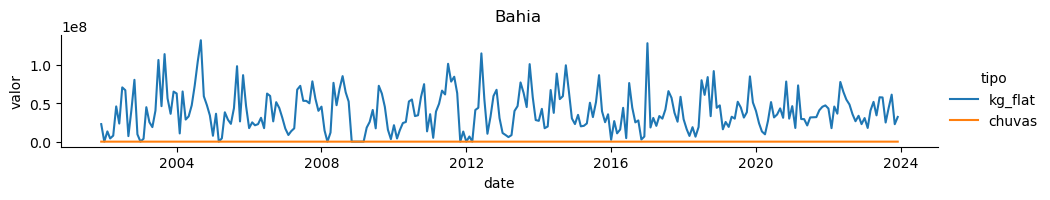

In [5]:
icl=pd.concat([
    i_c[['date','kg_flat']].rename(columns={'kg_flat':'valor'}).assign(tipo='kg_flat'),
    i_c[['date','mm'        ]].rename(columns={'mm'        :'valor'}).assign(tipo='chuvas')
])                         
sns.relplot(data=icl,x='date',y='valor',hue='tipo', kind='line',height=2,aspect=3*1.6).fig.suptitle('Bahia')
plt.show()

In [6]:
i_c[['kg_scaled','mm_scaled']]=mms.fit_transform(i_c[['kg_flat','mm']])

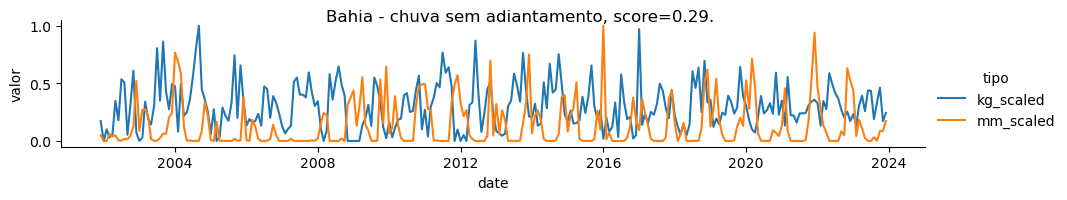

In [7]:
icl=pd.concat([
    i_c[['date','kg_scaled']].rename(columns={'kg_scaled':'valor'}).assign(tipo='kg_scaled'),
    i_c[['date','mm_scaled']].rename(columns={'mm_scaled':'valor'}).assign(tipo='mm_scaled')
              ]) 
score=round(metrics.mean_absolute_error(i_c.kg_scaled,i_c.mm_scaled),2)
sns.relplot(data=icl,x='date',y='valor',hue='tipo', kind='line',height=2,aspect=3*1.6).fig.suptitle(f'Bahia - chuva sem adiantamento, score={score}.')
plt.show()

In [8]:
def ad(df):
    
    ic_f=df.drop(columns=['mm','mm_scaled'])
    ic_c=df.drop(columns=['kg_flat','kg_scaled'])
    ic_c.CO_MES=df.CO_MES+1
    ic_c.loc[ic_c.CO_MES==13,'CO_ANO']=ic_c[ic_c.CO_MES==13].CO_ANO+1
    ic_c.loc[ic_c.CO_MES==13,'CO_MES']=1
    ic_c.date=pd.to_datetime(ic_c.CO_ANO.astype(str)+'/'+ic_c.CO_MES.astype(str))
    df=ic_c.merge(ic_f)
    return df

In [9]:
def ad_plot(df):
    global i_c
    i_c=ad(df)
    score=round(metrics.mean_absolute_error(i_c.kg_scaled,i_c.mm_scaled),2)
    icl=pd.concat([df[['date','kg_scaled']].rename(columns={'kg_scaled':'valor'}).assign(tipo='kg_scaled'),df[['date','mm_scaled']].rename(columns={'mm_scaled':'valor'}).assign(tipo='mm_scaled')]) 
    sns.relplot(data=icl,x='date',y='valor',hue='tipo', kind='line',height=2,aspect=3*1.6).fig.suptitle(f'Bahia - chuva adiantada em {adi} mês, score={score}.')
    plt.show()

In [10]:
for adi in range(1,11):
    ad_plot(i_c)

ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

In [17]:
for ad in range(1,12):
    ad_plot(i_c)

TypeError: 'int' object is not callable

3.1 Eliminar as tendências de longo prazo

3.1.1 Fertilizantes

In [3]:
p=np.poly1d(np.polyfit(i_c.date.astype(int),i_c.KG_LIQUIDO, deg=2))
i_c['kg_tendência']=p(i_c.date.astype(int))

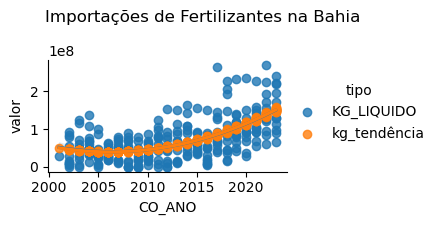

In [4]:
i_c_l=pd.concat([
    i_c[['CO_ANO','KG_LIQUIDO'  ]].rename(columns={'KG_LIQUIDO'  :'valor'}).assign(tipo='KG_LIQUIDO'),
    i_c[['CO_ANO','kg_tendência']].rename(columns={'kg_tendência':'valor'}).assign(tipo='kg_tendência')
])

sns.lmplot(data=i_c_l,x='CO_ANO',y='valor',hue='tipo', order=2, height=2,aspect=1.6).fig.suptitle('Importações de Fertilizantes na Bahia',y=1.1)
plt.show()

In [5]:
i_c['kg_tendência_flat']=i_c.KG_LIQUIDO/i_c.kg_tendência*i_c.kg_tendência.mean()

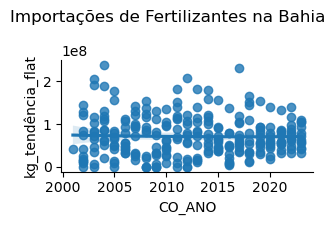

In [178]:
sns.lmplot(data=i_c,x='CO_ANO',y='kg_tendência_flat', order=2, height=2,aspect=1.6).fig.suptitle('Importações de Fertilizantes na Bahia',y=1.1)
plt.show()

3.1.2 Chuva

In [179]:
p=np.poly1d(np.polyfit(i_c.date.astype(int),i_c.mm, deg=2))
i_c['mm_tendência']=p(i_c.date.astype(int))

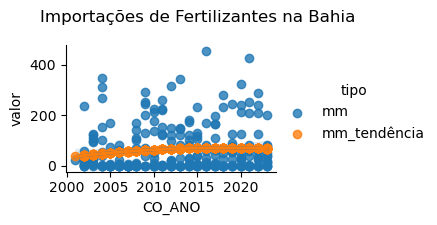

In [180]:
i_c_l=pd.concat([
    i_c[['CO_ANO','mm'          ]].rename(columns={'mm'          :'valor'}).assign(tipo='mm'),
    i_c[['CO_ANO','mm_tendência']].rename(columns={'mm_tendência':'valor'}).assign(tipo='mm_tendência')
])

sns.lmplot(data=i_c_l,x='CO_ANO',y='valor',hue='tipo', order=2, height=2,aspect=1.6).fig.suptitle('Importações de Fertilizantes na Bahia',y=1.1)
plt.show()

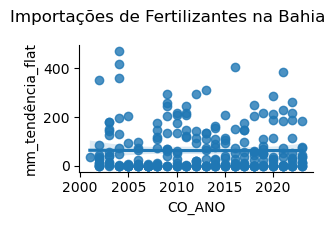

In [181]:
i_c['mm_tendência_flat']=i_c.mm/i_c.mm_tendência*i_c.mm_tendência.mean()

sns.lmplot(data=i_c,x='CO_ANO',y='mm_tendência_flat', order=2, height=2,aspect=1.6).fig.suptitle('Importações de Fertilizantes na Bahia',y=1.1)
plt.show()

3.2 Eliminar as sazonalidades

Como de forma preliminar se acredita que chuvas em um determinado mês pode afetar importações de meses a frente no tempo, para compara-los na mesma escala, faz-se necessário a eleiminação da sazonalidade mensal dos dados.

3.2.1 Fertilizantes

In [182]:
# Determinam-se as médias mensais e anuais
kg=i_c.groupby('CO_MES').kg_tendência_flat.mean().reset_index().rename(columns={'kg_tendência_flat':'kg_tendência_flat_mean_mes'})
kg['kg_tendência_flat_mean_ano']=i_c.kg_tendência_flat.mean()
mm=i_c.groupby('CO_MES').mm_tendência_flat.mean().reset_index().rename(columns={'mm_tendência_flat':'mm_tendência_flat_mean_mes'})
mm['mm_tendência_flat_mean_ano']=i_c.mm_tendência_flat.mean()
i_c=i_c.merge(kg).merge(mm)
i_c.head(1)

,date,CO_ANO,CO_MES,KG_LIQUIDO,mm,kg_tendência,kg_tendência_flat,mm_tendência,mm_tendência_flat,kg_tendência_flat_mean_mes,kg_tendência_flat_mean_ano,mm_tendência_flat_mean_mes,mm_tendência_flat_mean_ano
0,2001-12-01,2001,12,28011377.0,23.2,4.832488e+07,4.114496e+07,38.992557,37.556373,5.458260e+07,7.111773e+07,155.814583,63.17717


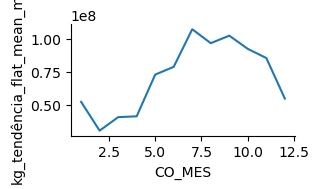

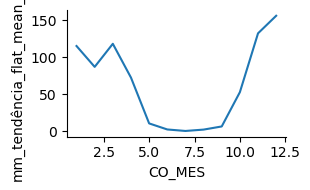

In [183]:
sns.relplot(height=2,aspect=1.6,data=kg,x='CO_MES',y='kg_tendência_flat_mean_mes', kind='line')
sns.relplot(height=2,aspect=1.6,data=mm,x='CO_MES',y='mm_tendência_flat_mean_mes', kind='line')
plt.show()

In [184]:
i_c['kg_desaz']=i_c.kg_tendência_flat/i_c.kg_tendência_flat_mean_mes*i_c.kg_tendência_flat_mean_ano
i_c['mm_desaz']=i_c.mm_tendência_flat/i_c.mm_tendência_flat_mean_mes*i_c.mm_tendência_flat_mean_ano

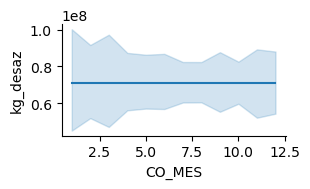

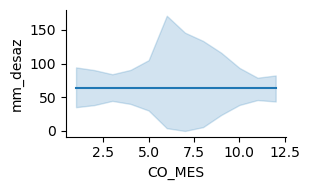

In [185]:
sns.relplot(height=2,aspect=1.6,data=i_c,x='CO_MES',y='kg_desaz', kind='line')
sns.relplot(height=2,aspect=1.6,data=i_c,x='CO_MES',y='mm_desaz', kind='line')
plt.show()

In [186]:
i_c.loc[i_c.mm_desaz!=0,'mm_desaz']=np.log(i_c.mm_desaz)
i_c=i_c.rename(columns={'mm_desaz':'mm_desaz_log'})

In [187]:
from sklearn.preprocessing import MinMaxScaler as mms
mms=mms()

In [194]:
i_c=i_c.assign(kg_mms=mms.fit_transform(i_c[['kg_desaz']])).assign(mm_mms=mms.fit_transform(i_c[['mm_desaz_log']]))
i_c.head(1)

KeyError: "None of [Index(['mm_desaz'], dtype='object')] are in the [columns]"

In [189]:
i_c.date.head()

0   2001-12-01
1   2002-12-01
2   2003-12-01
3   2004-12-01
4   2005-12-01
Name: date, dtype: datetime64[ns]

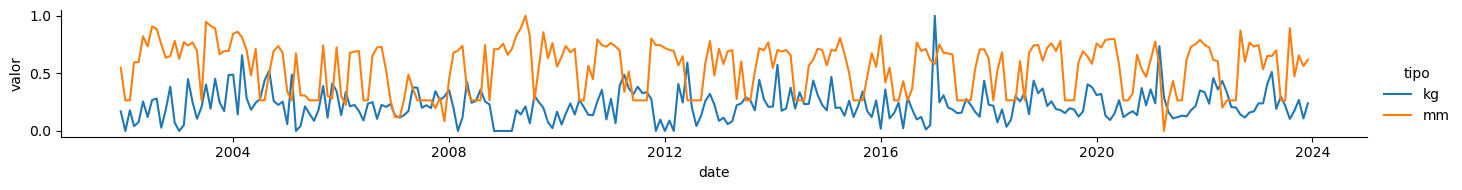

In [191]:
icl=pd.concat([
    i_c[['date','kg_mms']].rename(columns={'kg_mms':'valor'}).assign(tipo='kg'),
    i_c[['date','mm_mms']].rename(columns={'mm_mms':'valor'}).assign(tipo='mm')
])
sns.relplot(height=2,aspect=7,data=icl,x='date',y='valor',hue='tipo',kind='line')

3.1. Transformar os dados de ambas as fontes para uma mesma escala.

In [54]:
from sklearn.preprocessing import MinMaxScaler as mms
mms=mms()
i_c_mms=pd.DataFrame(mms.fit_transform(i_c[['KG_LIQUIDO','mm']]))
i_c_mms.columns=['KG_mms','mm_mms']
i_c=pd.concat([i_c,i_c_mms],axis=1)
i_c.head(1)

,date,CO_ANO,CO_MES,KG_LIQUIDO,mm,KG_mms,mm_mms
0,2001-12-01,2001,12,28011377.0,23.2,0.103869,0.051056


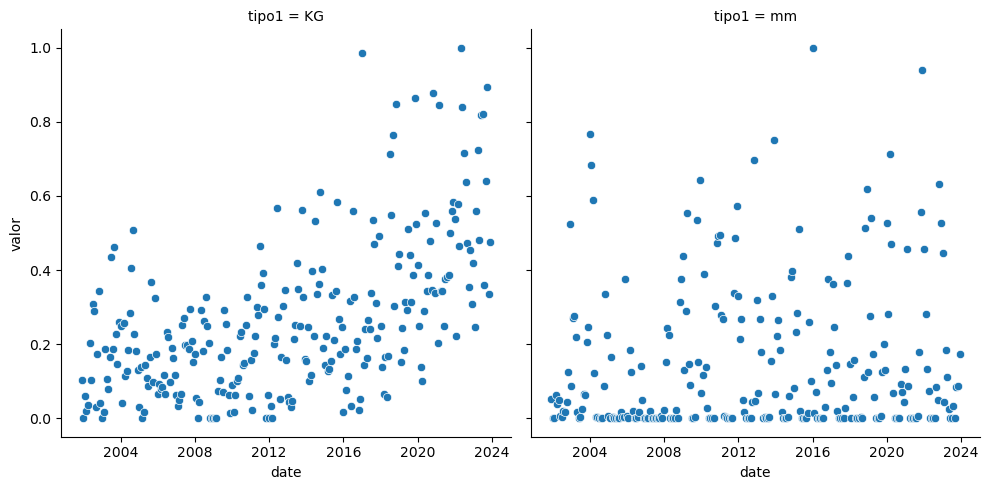

In [62]:
i_c_l=pd.concat([
    i_c[['date','KG_mms']].assign(tipo1='KG').rename(columns={'KG_mms':'valor'}),
    i_c[['date','mm_mms']].assign(tipo1='mm').rename(columns={'mm_mms':'valor'})
])
sns.relplot(data=i_c_l,x='date',y='valor',col='tipo1')

3.2. Eliminação da tendência de longo prazo:  

In [55]:
i_c.date=i_c.date.astype(int)

In [56]:
i_c['KG_mms_tend']=np.poly1d(np.polyfit(i_c.date,i_c.KG_mms, deg=2))(i_c.date)

In [57]:
i_c['mm_tend']=np.poly1d(np.polyfit(i_c.date,i_c.mm        , deg=2))(i_c.date)

In [58]:
i_c.date=i_c.date.astype('datetime64[ns]')

A seguir uma cópia da tabela é criada e transformada para o formato longo, apenas para gerar o gráfico a seguir.

In [59]:
i_c_l=pd.concat([
    i_c[['date','KG_LIQUIDO']].assign(tipo1='Importação de Fertilizantes').assign(tipo2='Real'     ).rename(columns={'KG_LIQUIDO':'valor'}),
    i_c[['date','KG_tend'   ]].assign(tipo1='Importação de Fertilizantes').assign(tipo2='Tendência').rename(columns={'KG_tend'   :'valor'}),
    i_c[['date','mm'        ]].assign(tipo1='Volume de Chuva'            ).assign(tipo2='Real'     ).rename(columns={'mm'        :'valor'}),
    i_c[['date','mm_tend'   ]].assign(tipo1='Volume de Chuva'            ).assign(tipo2='Tendência').rename(columns={'mm_tend'   :'valor'})    
])

KeyError: "['KG_tend'] not in index"

In [ ]:
sns.relplot(height=2, aspect=1.618,data=i_c_l,x='date',y='valor',col='tipo1', hue='tipo2').fig.suptitle('Bahia',y=1.1)
plt.show()

In [26]:
i_c.head(1)

,date,CO_ANO,CO_MES,KG_LIQUIDO,mm,KG_mms,mm_mms,KG_mms_tend,mm_mms_tend
0,2001-12-01,2001,12,28011377.0,23.2,0.103869,0.051056,0.179194,0.085811


In [27]:
i_c['KG_mms_flat']=i_c.KG_mms/i_c.KG_mms_tend
i_c['mm_mms_flat' ]=i_c.mm_mms/i_c.mm_mms_tend

In [28]:
i_c_l=pd.concat([
    i_c[['date','KG_mms_flat'     ]].assign(tipo1='Importação de Fertilizantes').rename(columns={'KG_mms_flat'     :'valor'}),
    i_c[['date','mm_mms_flat'     ]].assign(tipo1='Volume de Chuva'            ).rename(columns={'mm_mms_flat'     :'valor'})   
])

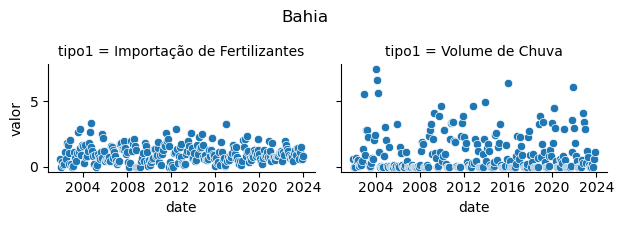

In [29]:
sns.relplot(height=2, aspect=1.618,data=i_c_l,x='date',y='valor',col='tipo1').fig.suptitle('Bahia',y=1.1)
plt.show()

3.2. Eliminação da sazonalidade mensal:  

A sazonalidade das chuvas é classicamente conhecida.

Também é facilemnte compreendido que uma chuva ocorrida em um determinado mês não pode impactar o desembarque de fertilizantes imediatamente, ou seja, no mesmo mês.

Para se comparar diferentes meses de chuvas e de importações, as sazonalidades devem ser eliminadas e isso é obtido subtraindo-se o valor médio de cada mês do valor real.

In [30]:
i_c.head(1)

,date,CO_ANO,CO_MES,KG_LIQUIDO,mm,KG_mms,mm_mms,KG_mms_tend,mm_mms_tend,KG_mms_flat,mm_mms_flat
0,2001-12-01,2001,12,28011377.0,23.2,0.103869,0.051056,0.179194,0.085811,0.579647,0.594985


In [31]:
q=pd.DataFrame()
for mes in i_c.CO_MES.unique():
    i_c_m=i_c[i_c.CO_MES==mes]
    mean_KG_mms_flat=i_c_m.KG_mms_flat.mean()
    mean_mm_mms_flat=i_c_m.mm_mms_flat.mean()
    i_c_m['KG_mms_flat_desaz']=i_c_m.KG_mms_flat/mean_KG_mms_flat
    i_c_m['mm_mms_flat_desaz']=i_c_m.mm_mms_flat/mean_KG_mms_flat
    q=pd.concat([q,i_c_m])
i_c=q
i_c.head(1)

,date,CO_ANO,CO_MES,KG_LIQUIDO,mm,KG_mms,mm_mms,KG_mms_tend,mm_mms_tend,KG_mms_flat,mm_mms_flat,KG_mms_flat_desaz,mm_mms_flat_desaz
0,2001-12-01,2001,12,28011377.0,23.2,0.103869,0.051056,0.179194,0.085811,0.579647,0.594985,0.753811,0.773758


In [32]:
i_c_l=pd.concat([
    i_c[['date','KG_mms_flat_desaz'     ]].assign(tipo1='Importação de Fertilizantes').rename(columns={'KG_mms_flat_desaz'     :'valor'}),
    i_c[['date','mm_mms_flat_desaz'     ]].assign(tipo1='Volume de Chuva'            ).rename(columns={'mm_mms_flat_desaz'     :'valor'})   
])

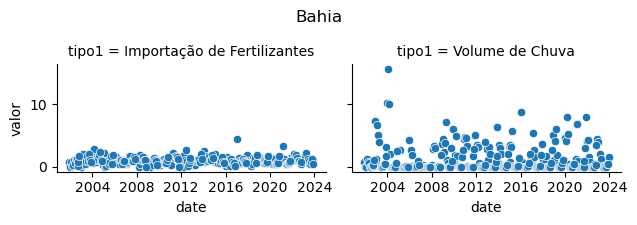

In [33]:
sns.relplot(height=2, aspect=1.618,data=i_c_l,x='date',y='valor',col='tipo1').fig.suptitle('Bahia',y=1.1)
plt.show()

In [65]:
i2['KG_LIQUIDO_resi']=i2.KG_LIQUIDO-i2.KG_LIQUIDO_fit

Finaliza as transformações nos registros de importação.

Para permitir a comparação visual entre as quantidades imortadas e os volumes de chuva, duas novas colunas são criadas com estes valores numa mesma escala de 0 a 1:

A seguir será eleimnada a sazonalidade das importações e das chuvas:

In [ ]:
# Cria médias mensais
KG_LIQUIDO_resi_m = i_c.groupby('CO_MES').KG_LIQUIDO_resi_mms.mean().reset_index().rename(columns={'KG_LIQUIDO_resi_mms':'KG_LIQUIDO_resi_mms_mean'})
mm_m              = i_c.groupby('CO_MES').mm_mms             .mean().reset_index().rename(columns={'mm_mms'     :'mm_mms_mean'     })

# Incorpora as colunas com as informações desazonalizaadas
i_c=i_c.merge(KG_LIQUIDO_resi_m).merge(mm_m)

# Cria-se novas colunas conténdo os desvios das médias de importações e de chuvas
i_c['KG_LIQUIDO_resi_mms_dif'] = i_c.KG_LIQUIDO_resi_mms - i_c.KG_LIQUIDO_resi_mms_mean
i_c['mm_mms_dif']              = i_c.mm_mms              - i_c.mm_mms_mean

Com certeza as chuvas nas regiões agrícolas não tem como modificar imediatamente o desembarque de fertilizantes no porto. Da mesma forma, não não é possível modificar o curso dos produtos que já estejam a caminho pelo mar. 

Para identificar o intervalo de tempo de impacto entre uma chuva irregular sobre um desembarque de importação, a seguir será testada a intensidade deste efeito em função de uma faixa de tempo entre os dois eventos. Vamos considerar que o tempo mínimo de embarque e viagem é de 60 dias.

In [ ]:
from sklearn import metrics

for ad in list([0])+list(range(3,13)):
    KG_LIQUIDO=i_c[['KG_LIQUIDO_resi_mms_dif']]
    mm=i_c[['mm_mms_dif']]
    mm.index=mm.index+ad
    i_c_1=pd.concat([KG_LIQUIDO,mm],axis=1).dropna()
    print(f"Adiantando {ad} meses-Média de Erro Absoluto={round(100*metrics.mean_absolute_error(i_c_1['mm_mms_dif'],i_c_1['KG_LIQUIDO_resi_mms_dif']),1)}")

print()

Observando os resultados acima podemos identificar que a aior similaridade dos valores, entre importações e chuva, foi aos 8 meses após as após a chuva.

Transforma-se a tabela para o formato longo, de forma a ser utilizado na construção dos gráficos a serem apresentados em seguida:

In [ ]:
# Produz i_c_l
a =i_c[['CO_ANO','CO_MES','date','KG_LIQUIDO_resi_mms_dif']].assign(tipo='KG_LIQUIDO_resi_mms_dif').rename(columns={'KG_LIQUIDO_resi_mms_dif':'mms_dif'})
b =i_c[['CO_ANO','CO_MES','date','mm_mms_dif'             ]].assign(tipo='mm_mms_dif'             ).rename(columns={'mm_mms_dif'             :'mms_dif'})
i_c_l=pd.concat([a,b])

In [ ]:
# Apresenta os gráfico de comparação das médias escalonadas entre as importações e as chuvas a cada ano ao longo dos meses
sns.relplot(height=3, aspect=1/1.618,kind='line',data=i_c_l,x='CO_MES',y='mms_dif',hue='tipo', col='CO_ANO',col_wrap=6).fig.suptitle("Proporção entre Chuvas e Importação de Fertilizantes",y=1.1)
plt.show()

Acima podemos ver que, as importações e a chuvas ocorridas não apresentam visualmente uma similaridade visual. A seguir faremos a mesma análise mas com as chuvas adiantadas 8 meses no tempo.

In [ ]:
a=i_c_l[i_c_l.tipo=='mm_mms_dif']

b=i_c_l[i_c_l.tipo!='mm_mms_dif']

a_ini=a.date.min()
a_fim=a.date.max()
ad=8
a.CO_MES=a.CO_MES+ad
for c in range(1,ad+1):
    a.loc[a.CO_MES==12+c,'CO_ANO']=a.loc[a.CO_MES==12+c]['CO_ANO']+1
    a.loc[a.CO_MES==12+c,'CO_MES']=c

a=a[(a.date>=a_ini)&(a.date<=a_fim)]
b=b.merge(a[['CO_ANO','CO_MES']])
i_c_l=pd.concat([a,b])
i_c_l=i_c_l.dropna()
i_c_l.head(1)

In [ ]:
sns.relplot(height=4,aspect=4,kind='line',data=i_c_l,x='date',y='mms_dif',hue='tipo',ci=None).fig.suptitle("Proporção entre Chuvas e Importação de Fertilizantes",y=1.1)
plt.show()

Após o adiantemento das chuvas proporcionou em alguns casos uma visualização de similaridade entre elas e as importações.

# CONCLUSÃO:  

Visualizamos graficamente que as linhas de chuvas parecem induzir movimentos nas linhas de importação, fazendo nos acreditar que é possível utilizar os dados a respeito das chuvas para refinar as previsões de importações de fertilizantes.